In [ ]:
!pip install -q cartopy fsspec scikit-learn scores zarr polars tqdm gcsfs xarray netCDF4 dask



## Problem Overview

Numerical weather prediction is peculiar in a way that surprises many folks outside of meteorology - rather than just produce the specific, precise forecast for something that a user might care about, these models instead simulate the entire atmosphere. Forecasts actually have to be backed out of the model output; raw model output lightly processed for use as a forecast is often called “guidance,” and comes with no guarantees about accuracy or bias.

ML weather models such as Google DeepMind’s GraphCast or NVIDIA’s FourCastNet emulate these numerical weather prediction systems, producing a subset of output that, essentially, simulates the whole atmosphere. So using them to create weather forecasts suffers the same problem as the numerical models - and that problem further extends to evaluating these models’ accuracy and performance.

Despite this problem, the ML-weather research community has made great strides in evaluating their models through projects like [WeatherBench](https://sites.research.google/weatherbench/). But WeaterBench and similar evaluation approaches have a fatal flaw when it comes to understanding how well ML weather models perform for forecasting applications: they’re not evaluated the way an end user might assess the forecast, which is focused on the specific performance of the model relative to a restricted set of observations for a particular forecast scenario. This is especially the case for extreme weather events, which may feature unique biases or failure modes that general, large-scale evaluation of the mean forecast fails to capture.

## Task

Our goal here is to begin sketching an approach for evaluating the performance of AI weather models for **heat waves**. We’ll specifically consider the [2021 Western North American Heat Wave](https://en.wikipedia.org/wiki/2021_Western_North_America_heat_wave), which took place between June 25 - July 7, 2021. We’ve curated a selection of regional, 10-day temperature forecasts produced by running the [Pangu-Weather](https://arxiv.org/abs/2211.02556) model, run from the GFS initial conditions every 12 hours between June 25 0Z and July 7 12Z (see contents below).

This is an open-ended exercise. Take a moment to skim through this Colab notebook, any of the links in the description above, or any other resource you think could be helpful. Then, let’s work collaboratively to answer some of the following questions:

1. How should one think about evaluating whether or not a forecast model performed adequately at predicting a heat wave?

2. What data sources could be used as ground truth or reference in the context of this evaluation?

3. What - if any - aspects of an operational weather forecasting system should be considered when performing these evaluations? (Hint: in an operational setting, a new forecast becomes available every 6 or 12 hour)

4. Can you discuss key technical challenges – related to data, software, infrastructure, etc – that may come up if we were to implement parts of the forecast model evaluation detailed so far?

5. How could the evaluation approach we’ve detailed be adapted or extended to compare and contrast the performance of different weather forecasting systems, leverage different ground truth data sources, or incorporate additional evaluation metrics or criteria?


It may be helpful to check out forecast and model evaluation packages, such as [scores](https://scores.readthedocs.io/en/stable/) or [scikit-learn](https://scikit-learn.org/stable/). But you are free to tackle this task using whatever tools you would like.

---


In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import gcsfs


import polars as pl
import zarr
import dask

import tqdm

In [ ]:
def get_panguweather_t2_forecasts() -> xr.Dataset:
    """Retrieve an xarray handle to a prepared data cube of Pangu-Weather forecasts."""
    return xr.open_dataset(
        "gcs://brightband-share/heatwave/pangu-weather-forecasts.t2.zarr",
        backend_kwargs=dict(
            storage_options=dict(
                token='anon'
            )
        ),
        engine="zarr"
    )

ml_ds = get_panguweather_t2_forecasts()
ml_ds

<xarray.Dataset> Size: 4GB
Dimensions:    (fcst_hour: 41, init_time: 26, latitude: 721, longitude: 1440)
Coordinates:
  * fcst_hour  (fcst_hour) int64 328B 0 6 12 18 24 30 ... 216 222 228 234 240
  * init_time  (init_time) datetime64[ns] 208B 2021-06-21 ... 2021-07-03T12:0...
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    time       (init_time, fcst_hour) datetime64[ns] 9kB ...
Data variables:
    t2         (init_time, fcst_hour, latitude, longitude) float32 4GB ...
Attributes:
    Conventions:           CF-1.8
    creation_time:         2023-11-22T05:29:06
    first_forecast_hour:   6
    forecast_hour_step:    6
    initialization_model:  GFS
    initialization_time:   2021-06-21T00:00:00
    last_forecast_hour:    240
    model_name:            Pangu-Weather
    model_version:         v1
    version:               1_2023-10-14

In [ ]:
def get_era5_analysis(
    fields: list[str]=['2m_temperature'],
    start_date: str="2021-06-21",
    end_date: str="2021-07-10"
) -> xr.Dataset:
    """Retrieve a subset of ERA5 data from the ARCO-ERA5 product.

    Args:
        fields: A list of field names, as strings, to subset from the analysis.
        {start,end}_date: A string in "%Y-%m-%d" format bracketing the time range
            to slice from the ERA5 dataset.
    Returns:
        An xarray.Dataset subset to the requested fields and time range, backed by
        lazy Zarr arrays referencing the ARCO-ERA5 product.

    """
    return (
        xr.open_dataset(
            "gcs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3",
            chunks=None,
            storage_options=dict(
                token='anon'
            ),
            engine='zarr'
        )
        [['2m_temperature']]
        .sel(
            time=slice("2021-06-21", "2021-07-10")
        )
    )

era5_ds = get_era5_analysis()
era5_ds

<xarray.Dataset> Size: 2GB
Dimensions:         (time: 480, latitude: 721, longitude: 1440)
Coordinates:
  * latitude        (latitude) float32 3kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude       (longitude) float32 6kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * time            (time) datetime64[ns] 4kB 2021-06-21 ... 2021-07-10T23:00:00
Data variables:
    2m_temperature  (time, latitude, longitude) float32 2GB ...
Attributes:
    valid_time_start:  1940-01-01
    last_updated:      2024-11-22 22:21:44.256607
    valid_time_stop:   2024-08-31

In [ ]:
def get_isd_lite_obs() -> pd.DataFrame:
    """Retrieve a pandas DataFrame pre-populated with observations for the
    2021 PNW heatwave.

    """
    fs = gcsfs.GCSFileSystem(token='anon')

    # Get list of files matching the pattern
    files = list(fs.glob("gs://brightband-share/heatwave/isd-lite/data-subset-*.parquet"))

    # Read all parquet files directly from GCS
    dfs = []
    for file in tqdm.tqdm(files):
        with fs.open(file) as f:
            df = pd.read_parquet(f)
            dfs.append(df)

    # Combine all dataframes
    return pd.concat(dfs, ignore_index=True)


def get_isd_station_metadata() -> pd.DataFrame:
    """Retrieve a DataFrame with metadata for all stations in the ISD-Lite dataset.

    """
    fs = gcsfs.GCSFileSystem(token='anon')
    with fs.open("gs://brightband-share/heatwave/isd-lite/isd-history.csv") as f:
        return pd.read_csv(f)


def get_station_data(df: pd.DataFrame, station: str) -> pd.DataFrame:
    """Subset a DataFrame by the station (ICAO) identifier, and convert to a timeseries.

    Args:
        df: the DataFrame to subset
        station: a string indicating the ICAO identifier for the requested station
    Returns:
        A pandas DataFrame subset to a specific station, with the index converted
        to an ordered timeseries.

    """

    return df.query("icao == @station").set_index('obs_timestamp').sort_index()


In [ ]:
obs_df = get_isd_lite_obs()
ksea_df = get_station_data(obs_df, "KSEA")
stations = get_isd_station_metadata()

100%|██████████| 100/100 [00:11<00:00,  8.64it/s]


In [ ]:
ml_ds, era5_ds, obs_df, stations = examine_data_structure()

100%|██████████| 100/100 [00:10<00:00,  9.43it/s]



Pangu-Weather Forecast Data:
Dimensions: FrozenMappingWarningOnValuesAccess({'fcst_hour': 41, 'init_time': 26, 'latitude': 721, 'longitude': 1440})
Variables: ['fcst_hour', 'init_time', 'latitude', 'longitude', 't2', 'time']

ERA5 Data:
Dimensions: FrozenMappingWarningOnValuesAccess({'time': 480, 'latitude': 721, 'longitude': 1440})
Variables: ['2m_temperature', 'latitude', 'longitude', 'time']

Station Observations:
Columns: ['obs_timestamp', 'air_temp', 'usaf', 'wban', 'station', 'country', 'state', 'icao']

Station Metadata:
Columns: ['USAF', 'WBAN', 'STATION NAME', 'CTRY', 'STATE', 'ICAO', 'LAT', 'LON', 'ELEV(M)', 'BEGIN', 'END']



Analyzing station KPDX

Processing data for station KPDX...


100%|██████████| 100/100 [00:10<00:00,  9.52it/s]


Station coordinates: 45.596°N, -122.609°E
Found 601 observations
Processing model data...
Identifying heat waves...
Heat wave threshold: 34.4°C
Analyzing forecasts...

Analyzing station KSEA

Processing data for station KSEA...


100%|██████████| 100/100 [00:09<00:00, 10.38it/s]


Station coordinates: 47.445°N, -122.314°E
Found 601 observations
Processing model data...
Identifying heat waves...
Heat wave threshold: 33.3°C
Analyzing forecasts...

Analysis complete!


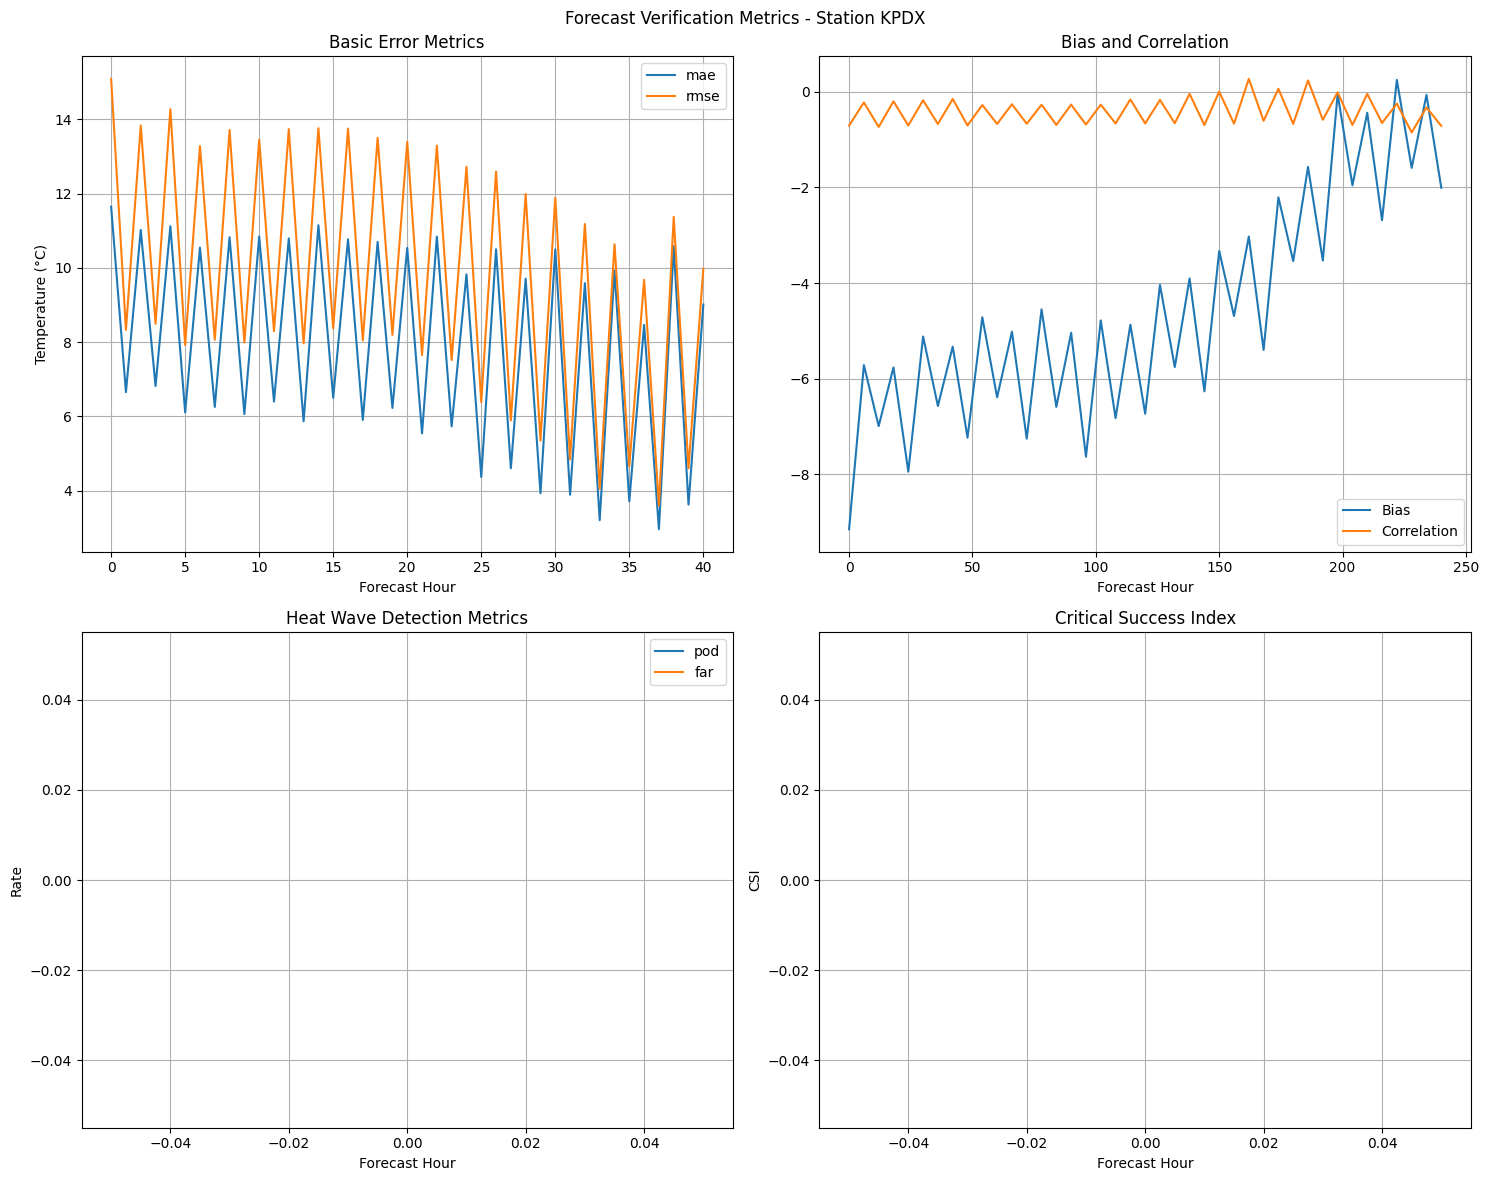

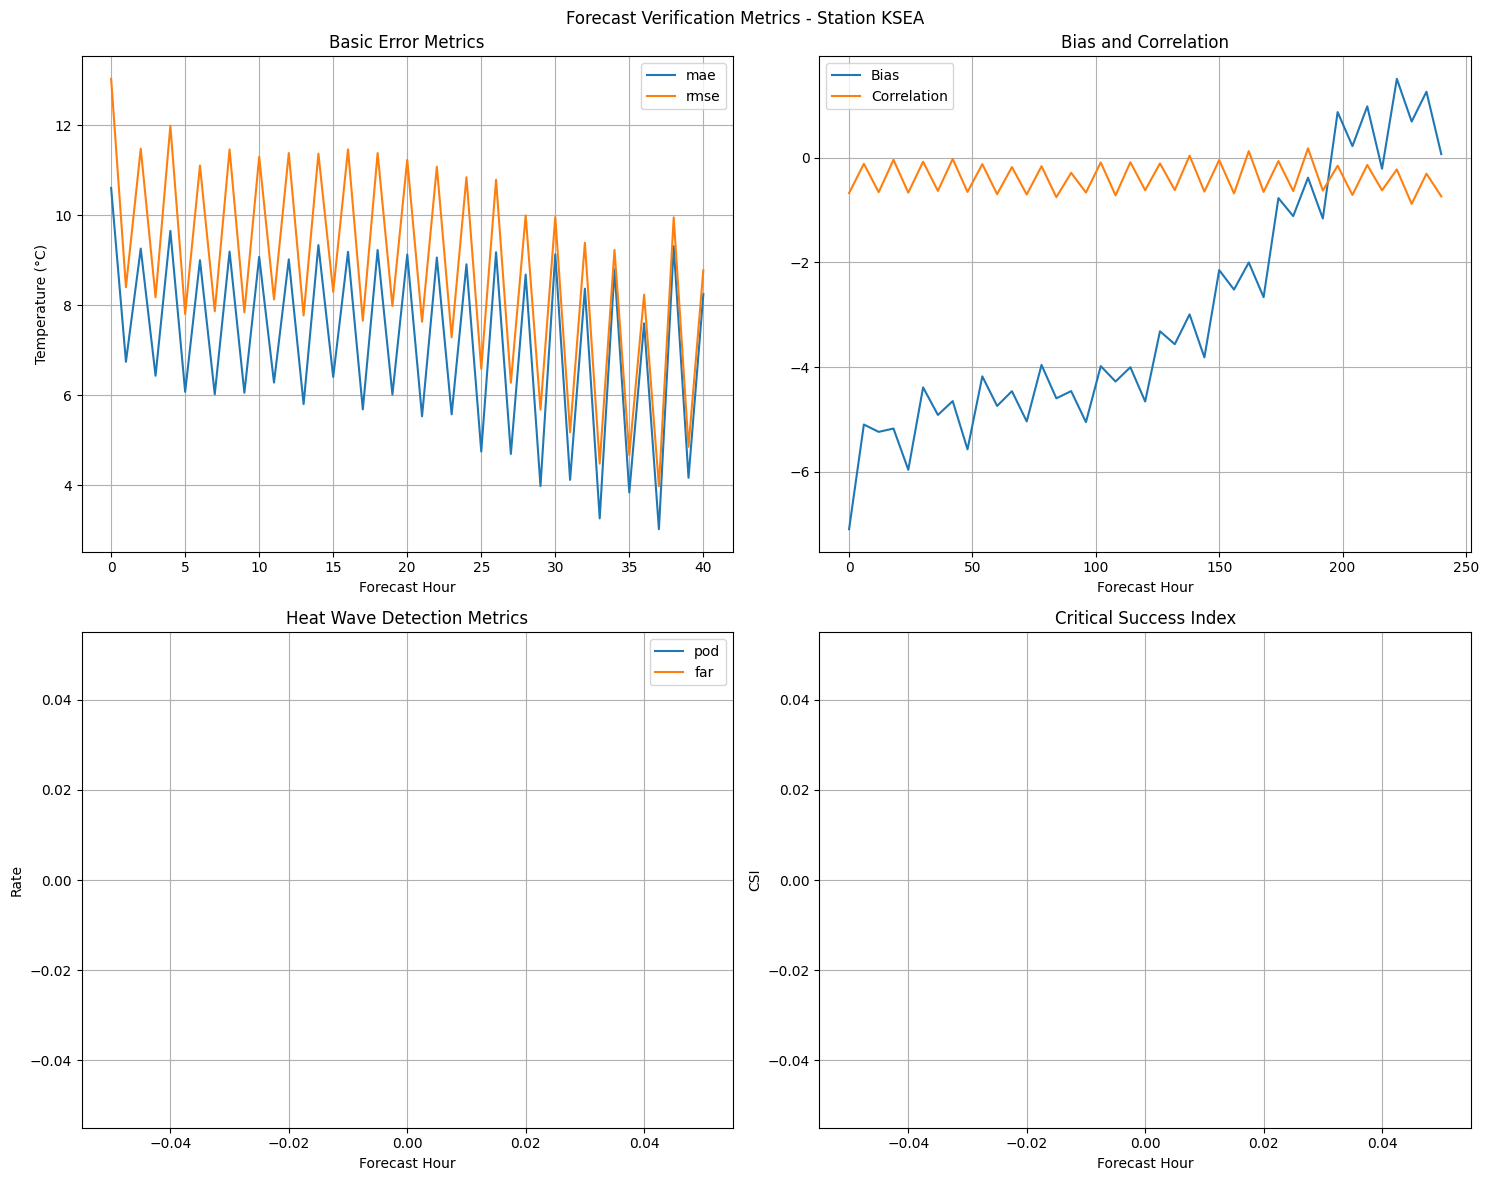

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

class HeatWaveAnalyzer:
    """Analyze heat wave forecasts."""

    def __init__(self, threshold_percentile=95, min_duration_hours=72):
        self.threshold_percentile = threshold_percentile
        self.min_duration_hours = min_duration_hours

    def process_data(self, station_id: str):
        """Load and process all required data for analysis."""
        print(f"\nProcessing data for station {station_id}...")

        # Load data
        ml_ds = get_panguweather_t2_forecasts()
        era5_ds = get_era5_analysis()
        obs_df = get_isd_lite_obs()
        stations = get_isd_station_metadata()

        # Get station metadata using ICAO identifier
        station_info = stations[stations['ICAO'] == station_id].iloc[0]
        station_lat = float(station_info['LAT'])
        station_lon = float(station_info['LON'])
        print(f"Station coordinates: {station_lat:.3f}°N, {station_lon:.3f}°E")

        # Process station observations
        station_data = get_station_data(obs_df, station_id)
        print(f"Found {len(station_data)} observations")

        # Convert temperatures
        station_data['temperature'] = station_data['air_temp'] / 10.0  # Convert to Celsius

        # Process model data
        print("Processing model data...")
        # Get nearest grid point forecasts
        ml_station = ml_ds.sel(
            latitude=station_lat,
            longitude=station_lon,
            method='nearest'
        )
        ml_station['t2'] = ml_station['t2'] - 273.15  # Convert K to C

        # Get ERA5 data
        era5_station = era5_ds.sel(
            latitude=station_lat,
            longitude=station_lon,
            method='nearest'
        )
        era5_station['2m_temperature'] = era5_station['2m_temperature'] - 273.15

        return station_data, ml_station, era5_station

    def identify_heat_waves(self, temperatures: pd.Series) -> tuple:
        """Identify heat wave periods."""
        threshold = np.nanpercentile(temperatures.dropna(), self.threshold_percentile)
        is_extreme = temperatures > threshold

        # Apply minimum duration requirement
        heat_waves = (
            is_extreme.rolling(window=self.min_duration_hours, min_periods=1)
            .sum()
            .ge(self.min_duration_hours)
        )
        return heat_waves, threshold

    def calculate_metrics(self, forecasts: np.ndarray, observations: np.ndarray) -> dict:
        """Calculate forecast verification metrics."""
        metrics = {
            'mae': mean_absolute_error(observations, forecasts),
            'rmse': np.sqrt(mean_squared_error(observations, forecasts)),
            'bias': np.mean(forecasts - observations)
        }

        # Calculate correlation if enough points
        if len(observations) > 1:
            metrics['correlation'] = np.corrcoef(observations, forecasts)[0,1]
        else:
            metrics['correlation'] = np.nan

        return metrics

    def calculate_heat_wave_metrics(
        self,
        forecast_events: np.ndarray,
        observed_events: np.ndarray
    ) -> dict:
        """Calculate heat wave specific metrics."""
        hits = np.sum((observed_events == 1) & (forecast_events == 1))
        misses = np.sum((observed_events == 1) & (forecast_events == 0))
        false_alarms = np.sum((observed_events == 0) & (forecast_events == 1))

        pod = hits / (hits + misses) if (hits + misses) > 0 else np.nan
        far = false_alarms / (hits + false_alarms) if (hits + false_alarms) > 0 else np.nan
        csi = hits / (hits + misses + false_alarms) if (hits + misses + false_alarms) > 0 else np.nan

        return {'pod': pod, 'far': far, 'csi': csi}

    def analyze_forecasts(self, station_id: str) -> pd.DataFrame:
        """Perform comprehensive forecast analysis."""
        # Process data
        station_data, ml_station, era5_station = self.process_data(station_id)

        # Initialize results storage
        results = []

        # Calculate heat wave threshold
        print("Identifying heat waves...")
        heat_waves, threshold = self.identify_heat_waves(station_data['temperature'])
        print(f"Heat wave threshold: {threshold:.1f}°C")

        # Analyze each forecast hour
        print("Analyzing forecasts...")
        for hour in ml_station.fcst_hour.values:
            hour_forecasts = ml_station.sel(fcst_hour=hour)
            matched_obs = []
            matched_fcst = []
            matched_times = []

            for init in hour_forecasts.init_time:
                valid_time = init.values + np.timedelta64(hour, 'h')
                valid_time = pd.Timestamp(valid_time)

                if valid_time in station_data.index:
                    matched_obs.append(station_data.loc[valid_time, 'temperature'])
                    matched_fcst.append(hour_forecasts.sel(init_time=init)['t2'].item())
                    matched_times.append(valid_time)

            if matched_obs:
                # Calculate basic metrics
                basic_metrics = self.calculate_metrics(
                    np.array(matched_fcst),
                    np.array(matched_obs)
                )

                # Calculate heat wave metrics
                times_idx = [t for t in matched_times if t in heat_waves.index]
                if times_idx:
                    obs_events = heat_waves.loc[times_idx].values
                    fcst_events = np.array(matched_fcst) > threshold
                    hw_metrics = self.calculate_heat_wave_metrics(fcst_events, obs_events)
                else:
                    hw_metrics = {
                        'pod': np.nan,
                        'far': np.nan,
                        'csi': np.nan
                    }

                # Store results
                results.append({
                    'forecast_hour': hour,
                    **basic_metrics,
                    **hw_metrics
                })

        return pd.DataFrame(results)

    def plot_results(self, results: pd.DataFrame, station_id: str):
        """Create visualizations of the analysis results."""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'Forecast Verification Metrics - Station {station_id}')

        # Plot error metrics
        results[['mae', 'rmse']].plot(ax=axes[0,0])
        axes[0,0].set_title('Basic Error Metrics')
        axes[0,0].set_xlabel('Forecast Hour')
        axes[0,0].set_ylabel('Temperature (°C)')
        axes[0,0].grid(True)

        # Plot bias and correlation
        axes[0,1].plot(results['forecast_hour'], results['bias'], label='Bias')
        axes[0,1].plot(results['forecast_hour'], results['correlation'], label='Correlation')
        axes[0,1].set_title('Bias and Correlation')
        axes[0,1].set_xlabel('Forecast Hour')
        axes[0,1].grid(True)
        axes[0,1].legend()

        # Plot POD/FAR
        results[['pod', 'far']].plot(ax=axes[1,0])
        axes[1,0].set_title('Heat Wave Detection Metrics')
        axes[1,0].set_xlabel('Forecast Hour')
        axes[1,0].set_ylabel('Rate')
        axes[1,0].grid(True)

        # Plot CSI
        results['csi'].plot(ax=axes[1,1])
        axes[1,1].set_title('Critical Success Index')
        axes[1,1].set_xlabel('Forecast Hour')
        axes[1,1].set_ylabel('CSI')
        axes[1,1].grid(True)

        plt.tight_layout()
        return fig

def main():
    """Main execution function."""
    # Initialize analyzer
    analyzer = HeatWaveAnalyzer()

    # Analyze Portland and Seattle
    stations = ['KPDX', 'KSEA']
    all_results = {}

    for station_id in stations:
        print(f"\nAnalyzing station {station_id}")
        results = analyzer.analyze_forecasts(station_id)
        all_results[station_id] = results

        # Plot results
        analyzer.plot_results(results, station_id)

    return all_results

if __name__ == "__main__":
    results = main()
    print("\nAnalysis complete!")

Loading data sources...


100%|██████████| 100/100 [00:10<00:00,  9.88it/s]



Forecast Data Dimensions: {'fcst_hour': 41, 'init_time': 26, 'latitude': 721, 'longitude': 1440}
Ground Truth Data Dimensions: {'time': 480, 'latitude': 721, 'longitude': 1440}
Station Data Columns: ['obs_timestamp', 'air_temp', 'usaf', 'wban', 'station', 'country', 'state', 'icao']
Station Metadata Columns: ['USAF', 'WBAN', 'STATION NAME', 'CTRY', 'STATE', 'ICAO', 'LAT', 'LON', 'ELEV(M)', 'BEGIN', 'END']

Analyzing station KPDX

Processing forecasts for KPDX at 45.60°N, -122.61°E
Processed 26 forecast initializations
Found 601 observations for KPDX

Evaluating heat wave prediction performance...
Heat wave threshold temperature: 34.4°C
Evaluated 26 forecasts

Analyzing station KSEA

Processing forecasts for KSEA at 47.45°N, -122.31°E
Processed 26 forecast initializations
Found 601 observations for KSEA

Evaluating heat wave prediction performance...
Heat wave threshold temperature: 33.3°C
Evaluated 26 forecasts

Evaluation complete!


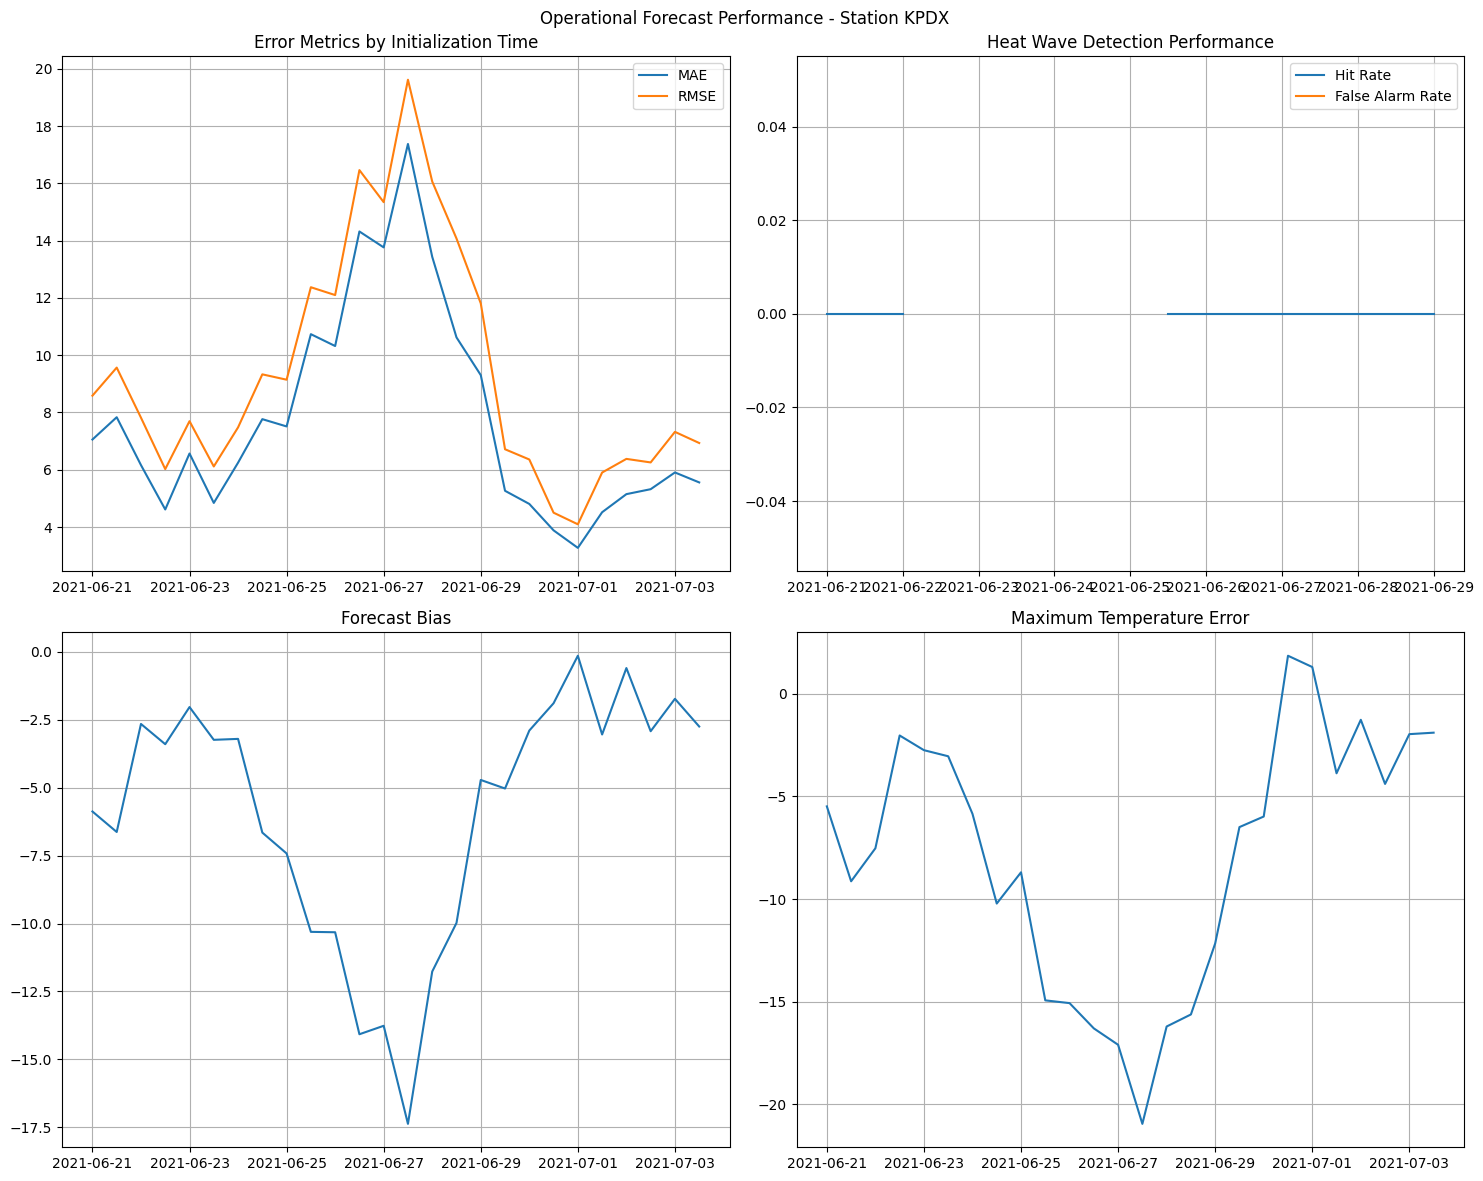

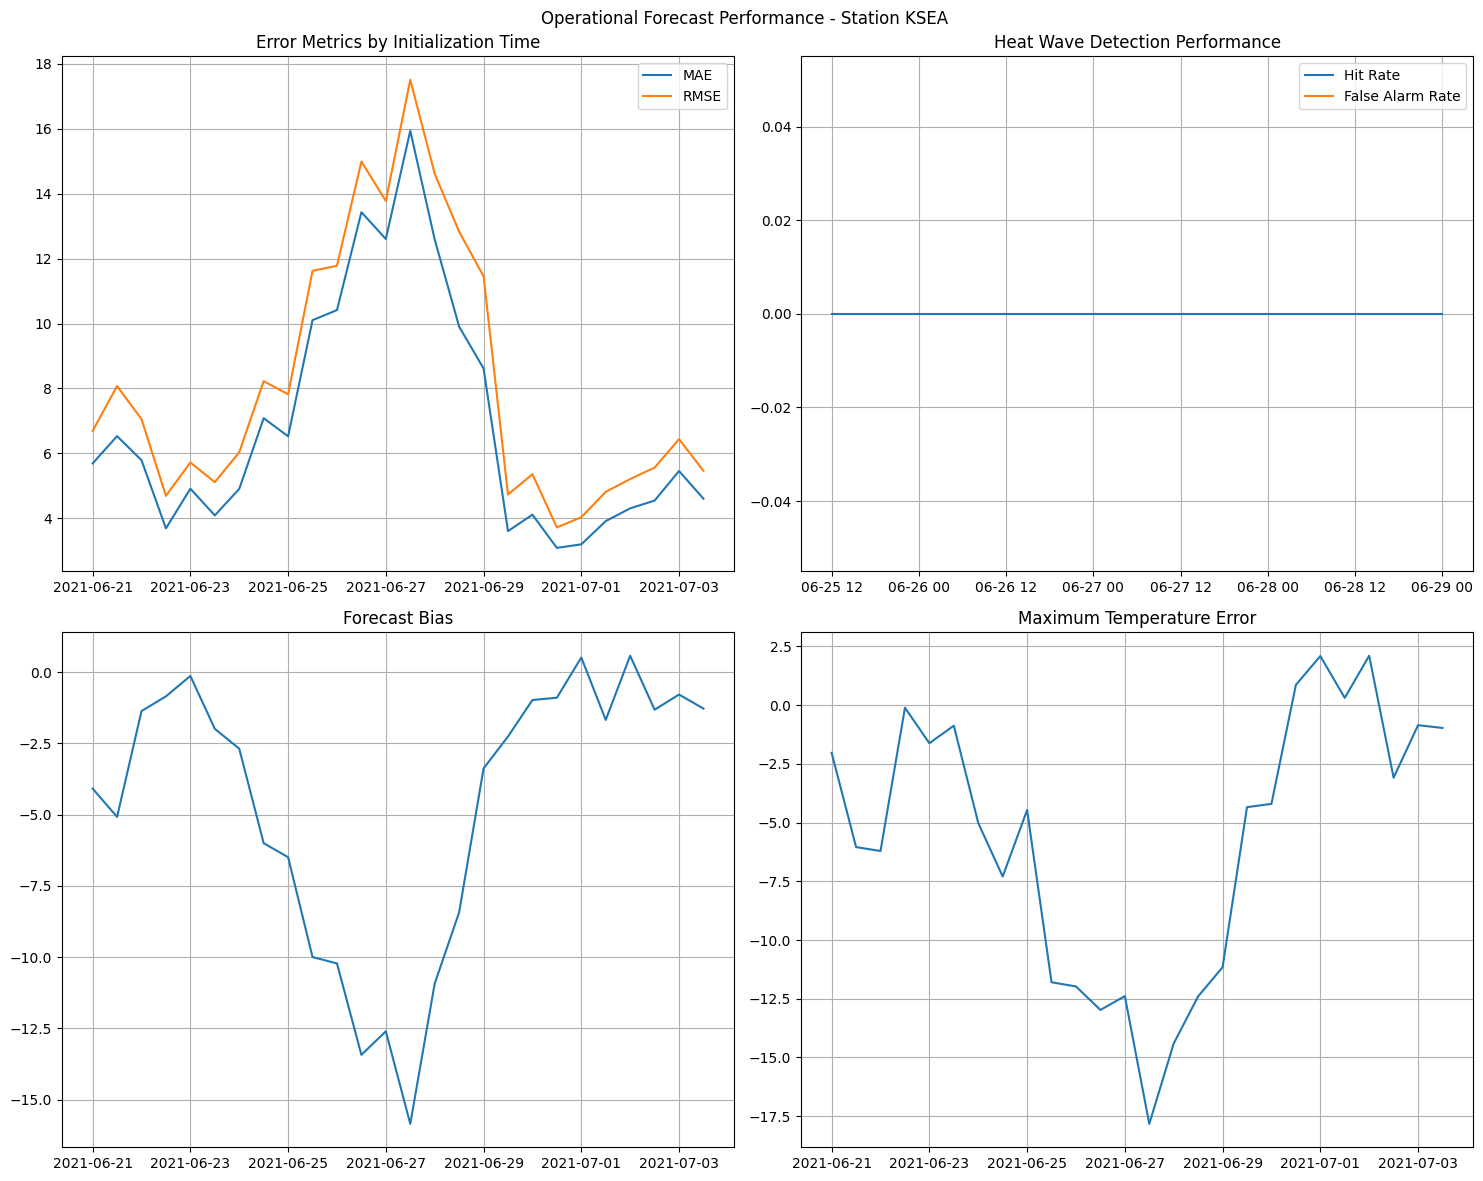

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error
from typing import Dict, Tuple, List
import warnings
warnings.filterwarnings('ignore')

class WeatherModelEvaluator:
    """Framework for evaluating AI weather model performance for heat waves."""

    def __init__(self):
        self.heat_wave_threshold_percentile = 95
        self.min_duration_hours = 72
        self.evaluation_period = slice('2021-06-25', '2021-07-07')

    def load_data_sources(self):
        """Load and examine multiple data sources."""
        print("Loading data sources...")

        # Load all data
        self.forecast_data = get_panguweather_t2_forecasts()
        self.ground_truth_data = get_era5_analysis()
        self.station_data = get_isd_lite_obs()
        self.station_metadata = get_isd_station_metadata()

        # Print data structure information
        print("\nForecast Data Dimensions:", dict(self.forecast_data.dims))
        print("Ground Truth Data Dimensions:", dict(self.ground_truth_data.dims))
        print("Station Data Columns:", self.station_data.columns.tolist())
        print("Station Metadata Columns:", self.station_metadata.columns.tolist())

        return self

    def prepare_operational_forecasts(self, station_id: str) -> Dict:
        """Prepare forecasts as they would be available operationally."""
        # Get station location
        station_info = self.station_metadata[self.station_metadata['ICAO'] == station_id].iloc[0]
        station_lat, station_lon = float(station_info['LAT']), float(station_info['LON'])

        print(f"\nProcessing forecasts for {station_id} at {station_lat:.2f}°N, {station_lon:.2f}°E")

        # Get nearest gridpoint forecasts
        forecasts = self.forecast_data.sel(
            latitude=station_lat,
            longitude=station_lon,
            method='nearest'
        )

        # Convert temperature to Celsius
        forecasts['t2'] = forecasts['t2'] - 273.15

        # Organize by initialization time
        forecast_dict = {}
        for init_time in forecasts.init_time:
            forecast_dict[pd.Timestamp(init_time.values)] = (
                forecasts.sel(init_time=init_time)['t2'].values
            )

        print(f"Processed {len(forecast_dict)} forecast initializations")
        return forecast_dict

    def prepare_observations(self, station_id: str) -> pd.Series:
        """Prepare ground truth observations."""
        # Filter station data
        station_data = self.station_data[self.station_data['icao'] == station_id].copy()

        # Convert temperature to Celsius
        station_data['temperature'] = station_data['air_temp'] / 10.0

        # Create datetime index
        station_data['datetime'] = pd.to_datetime(station_data['obs_timestamp'])
        station_data.set_index('datetime', inplace=True)

        print(f"Found {len(station_data)} observations for {station_id}")
        return station_data['temperature']

    def evaluate_heat_wave_prediction(
        self,
        forecasts: Dict,
        observations: pd.Series
    ) -> Dict:
        """Evaluate heat wave prediction performance."""
        print("\nEvaluating heat wave prediction performance...")

        results = {
            'initialization_times': [],
            'lead_times': [],
            'metrics': []
        }

        # Calculate heat wave threshold
        threshold = np.nanpercentile(observations, self.heat_wave_threshold_percentile)
        print(f"Heat wave threshold temperature: {threshold:.1f}°C")

        for init_time, forecast in forecasts.items():
            # Get valid times for this forecast
            valid_times = [
                init_time + pd.Timedelta(hours=h)
                for h in range(len(forecast))
            ]

            # Match observations
            matched_obs = []
            matched_fcst = []
            for i, valid_time in enumerate(valid_times):
                if valid_time in observations.index:
                    matched_obs.append(observations[valid_time])
                    matched_fcst.append(forecast[i])

            if matched_obs:
                # Calculate metrics
                metrics = {
                    'mae': mean_absolute_error(matched_obs, matched_fcst),
                    'rmse': np.sqrt(mean_squared_error(matched_obs, matched_fcst)),
                    'bias': np.mean(np.array(matched_fcst) - np.array(matched_obs))
                }

                # Heat wave specific metrics
                obs_events = np.array(matched_obs) > threshold
                fcst_events = np.array(matched_fcst) > threshold

                hits = np.sum((obs_events == 1) & (fcst_events == 1))
                misses = np.sum((obs_events == 1) & (fcst_events == 0))
                false_alarms = np.sum((obs_events == 0) & (fcst_events == 1))

                metrics.update({
                    'pod': hits / (hits + misses) if (hits + misses) > 0 else np.nan,
                    'far': false_alarms / (hits + false_alarms) if (hits + false_alarms) > 0 else np.nan,
                    'max_temp_error': max(matched_fcst) - max(matched_obs)
                })

                results['initialization_times'].append(init_time)
                results['lead_times'].append(len(matched_obs))
                results['metrics'].append(metrics)

        print(f"Evaluated {len(results['initialization_times'])} forecasts")
        return results

    def plot_operational_performance(self, results: Dict, station_id: str):
        """Visualize operational forecast performance."""
        if not results['initialization_times']:
            print("No results to plot")
            return None

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'Operational Forecast Performance - Station {station_id}')

        init_times = results['initialization_times']
        metrics = results['metrics']

        # Plot error metrics
        mae_values = [m['mae'] for m in metrics]
        rmse_values = [m['rmse'] for m in metrics]
        axes[0,0].plot(init_times, mae_values, label='MAE')
        axes[0,0].plot(init_times, rmse_values, label='RMSE')
        axes[0,0].set_title('Error Metrics by Initialization Time')
        axes[0,0].legend()
        axes[0,0].grid(True)

        # Plot heat wave detection metrics
        pod_values = [m['pod'] for m in metrics]
        far_values = [m['far'] for m in metrics]
        axes[0,1].plot(init_times, pod_values, label='Hit Rate')
        axes[0,1].plot(init_times, far_values, label='False Alarm Rate')
        axes[0,1].set_title('Heat Wave Detection Performance')
        axes[0,1].legend()
        axes[0,1].grid(True)

        # Plot bias
        bias_values = [m['bias'] for m in metrics]
        axes[1,0].plot(init_times, bias_values)
        axes[1,0].set_title('Forecast Bias')
        axes[1,0].grid(True)

        # Plot maximum temperature errors
        max_temp_errors = [m['max_temp_error'] for m in metrics]
        axes[1,1].plot(init_times, max_temp_errors)
        axes[1,1].set_title('Maximum Temperature Error')
        axes[1,1].grid(True)

        plt.tight_layout()
        return fig

def main():
    """Main execution function demonstrating the evaluation framework."""
    # Initialize and load data
    evaluator = WeatherModelEvaluator()
    evaluator.load_data_sources()

    # Analyze key stations
    stations = ['KPDX', 'KSEA']  # Portland and Seattle
    all_results = {}

    for station_id in stations:
        print(f"\nAnalyzing station {station_id}")

        # Prepare data
        forecasts = evaluator.prepare_operational_forecasts(station_id)
        observations = evaluator.prepare_observations(station_id)

        # Evaluate performance
        results = evaluator.evaluate_heat_wave_prediction(forecasts, observations)
        all_results[station_id] = results

        # Visualize results
        evaluator.plot_operational_performance(results, station_id)

    return all_results

if __name__ == "__main__":
    results = main()
    print("\nEvaluation complete!")